<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-09-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "John Hayes" #@param {type:"string"}
Student_full_name = "9309888" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml

import datetime

#### Any functions that will be used later on

In [7]:
def run_model(x_data, y_data, iterations, sample_size):
    """
    Execute the model for a given data set
    """
    with pm.Model() as model:
        
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
  
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=x_data.shape[1])
  
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
  
        # linear regression relationship
        # linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, x_data.T)
        
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_data[:,0])

    with model:
        
        # iterations of the algorithm
        approximation = pm.fit(iterations,method='advi')

    # samples from the posterior   
    posterior = approximation.sample(sample_size)
    
    return posterior, approximation

#------------------------------------------------------------
def random_replace_with_nan(dataframe, frac):
    """
    Replace some values randomly with nan
    """
  
    # requires numpy & pandas
    rows = np.random.choice(range(dataframe.shape[0]), int(dataframe.shape[0]*frac), replace=False)
    cols = np.random.choice(range(0,dataframe.shape[1]-1), size=len(rows), replace=True)
    
    to_repl = [np.nan for i, col in zip(rows, cols)] 
      
    # method used to cast a pandas object to a specified dtype
    rnan = dataframe.astype(object).to_numpy() 
    rnan[rows, cols] = to_repl
    
    # returns data frame with nans
    return DataFrame(rnan, index=dataframe.index, columns=dataframe.columns)

#------------------------------------------------------------
def replace_with_nan(dataframe, frac):
    return dataframe

#------------------------------------------------------------
def ppc(alpha, beta, sigma, X, nsamples=500):
    """
    # Posterior predictive checks (PPCs)
    """
    
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        
        # we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
        
    return Ypred

#------------------------------------------------------------
def train_cluster(x_train, x_test):
    """
    Train the cluster
    """
    
    Xn = x_train[clusters_train==0,:]
    Xtestn = x_test[clusters_test==0,:]

    ylog = np.log(ys_train.astype('float')[clusters_train==0,:])
    yscaler = StandardScaler().fit(ylog)
    yn = yscaler.transform(ylog)
    
    return ylog, yscaler, Xn, yn

#------------------------------------------------------------
def cluster_sim(posterior, Xn, num_samples=200):
    """
    display a prediction for a single cluster
    """
    
    # Simulation
    Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],
                                            posterior['beta'],
                                            posterior['sigma_n'],
                                            Xn,
                                            nsamples=num_samples))
    for i in range(Ypred.shape[0]):
        az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
        
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
    #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
    #plt.xlim([0,10e7])
    
    az.plot_dist(ylog,label='true observations');
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");
    

#### Some variables that will be used throughout

In [8]:
num_iter = 50000
sample_size = 5000
num_of_models = 4

# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# Dataset <a id='the_dataset'></a>

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

#### TODO
* Think about using it to predict house price crash as well - how much you could loose and possibly what the bottom for a set of houses in an area might be ?
    * sq feet, 
    * number of beds vs bathrooms - is there a relationship between those 2 vars ?
    * Garden size available ?.
    * Apartment vs semi or fully detached
    * Investor will also want rental values for an area.
    * Sub-concious bias given my age/profile and the subject matter ?
* Can itbe useful to figure how long a rise/fall might last ? - what other factors would you need for this ?
* Also state that you are taking the data in each column at face value.
* You will need to manually extract some data from the 'description' column - how common is certain types of data in that column ?
* How to estimate the various breakpoints ? - typically not know before the analysis.
* Are the breakpoints continuous in this case ? - maybe not
* Compare each of the various different vars above to the true figure to see how well they map

#### Load the dataset <a id='loading_dataset'></a>
Using a generic loader for local and colab based notebook only works when the data has a unique ID such as the MNIST dataset. The house data doesn't AFAIK

In [9]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Etivity2-Data/'
    
else:
    Path = "./"
    
# House price data from csv files
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
true_price_data = Path + 'true_price.csv'

# Can't drop the ad id as it is linked to the true data
# Training data
df_orig_train_data = pd.read_csv(train_data)
X_train = df_orig_train_data.values
#y_train = df_train_data.values
print("Testing data {}".format(X_train.shape))

# Test data
df_test_data = pd.read_csv(test_data)
X_test = df_test_data.values
#y_test = df_test_data.ad_id.values
print("Test data {}".format(X_test.shape))

# True data
df_true_cost = pd.read_csv(true_price_data)
X_true = df_true_cost.values
#y_true = df_true_data.Id.values
print("True prices data {}".format(X_true.shape))

#image_dimension = int(np.sqrt(X_test.shape[1]))
#print("Using {} as image dimension".format(image_dimension))

Testing data (2982, 17)
Test data (500, 16)
True prices data (500, 2)


#### Features to use
Having looked at all the headings (`ad_id, area, bathrooms, beds, ber_classification, county, description_block, environment, facility, features, latitude, longitude, no_of_units, price, property_category, property_type, surface`) and the data for each of those in the training set, I have decided to use:
* `latitude` and `lognitue` as suggested by the Etivity
* `area` and `county`
* `area` and `county` and `no_of_units`

I am not using Number of bedrooms or bathrooms as they have quite a number of empty values.

#### Clean the dataset - remove Nan and possible outliers

In [10]:
# TODO Empty placeholder for now
df_train_data = replace_with_nan(df_orig_train_data, 0.0)

## Training & Test Data

In [11]:
# split data into training and test
#from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset <a id='training_dataset'></a>

In [12]:
# training dataset: 
#training_file = syntPath+filename1
# test dataset: 
#testing_file = syntPath+filename2
# cost dataset: 
#cost_file = syntPath+filename3

In [13]:
# show first data frame rows 
df_train_data.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [14]:
# Generate descriptive statistics
df_train_data.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


### Test dataset <a id='test_dataset'></a>

In [15]:
# show first data frame rows 
df_test_data.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [16]:
# Generate descriptive statistics
df_test_data.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


### Expected Cost dataset

In [17]:
df_true_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [18]:
# Generate descriptive statistics
df_true_cost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


# Piecewise Regression <a id='piecewise_regression'></a>
The first part of this task is to apply a full model and then use subsets of the data to create clusters and apply a model to each of those.

## Apply a full model

In [19]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# will use these when I have a categorical conversion decided on
# featrain = ['area','county','property_category','property_type']

# Using existing digit values for ease of 1st run.
#featrain = ['latitude','longitude','beds','no_of_units']
featrain = ['latitude','longitude','beds', 'bathrooms']

# dropna: remove missing values
df_subset_train = df_train_data[featrain].dropna(axis=0)
#print(df_subset_train)

# Also remove columns with 0 - causes problems for the scalers used below
df_subset_train = df_subset_train[(df_subset_train.beds>0)]
df_subset_train = df_subset_train[(df_subset_train.bathrooms>0)]
#print(df)

# This will remove all columns that have ANY values less than 0.1
#df_subset_train = df_subset_train[(df_subset_train > 0.1).all(axis=1)]
#print(df_subset_train)

#featest = ['area','county','property_category','property_type']
featest = ['latitude','longitude','beds']

df_subset_test = df_test_data[featest].dropna(axis=0)
print(df_subset_test)

# cost
df_cost = df_true_cost[df_true_cost.index.isin(df_subset_test.index)]

      latitude  longitude  beds
0    53.566881  -6.101148   4.0
1    53.362992  -6.452909   3.0
2    53.454198  -6.262964   4.0
3    53.354402  -6.458647   3.0
4    53.336530  -6.393587   3.0
..         ...        ...   ...
495  53.342207  -6.226101   2.0
496  53.261475  -6.147720   5.0
497  53.391619  -6.205157   3.0
498  53.360578  -6.183701   4.0
499  53.366827  -6.248329   2.0

[500 rows x 3 columns]


In [20]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [21]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values

# train set, output column, property_type
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)
print(ys_train)
print(type(df_subset_train))
print(df_subset_train)

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values

# test set, output column, cost
y_test = df_cost.Expected.values
print(type(y_test))

[[3.]
 [4.]
 [3.]
 ...
 [1.]
 [2.]
 [2.]]
<class 'pandas.core.frame.DataFrame'>
       latitude  longitude  beds  bathrooms
15    53.400454  -6.445730   5.0        3.0
26    53.316410  -6.385214   4.0        4.0
27    53.401414  -6.446634   5.0        3.0
35    53.375377  -6.056749   5.0        5.0
38    53.372130  -6.338466   2.0        2.0
...         ...        ...   ...        ...
2977  53.338738  -6.237199   2.0        2.0
2978  53.335793  -6.294268   3.0        1.0
2979  53.346098  -6.276856   2.0        1.0
2980  53.273518  -6.178500   3.0        2.0
2981  53.310073  -6.325158   3.0        2.0

[2859 rows x 4 columns]
<class 'numpy.ndarray'>


In [22]:
print(Xs_train)

[[53.40045411 -6.44573026  5.        ]
 [53.31641013 -6.38521365  4.        ]
 [53.40141406 -6.44663439  5.        ]
 ...
 [53.346098   -6.276856    2.        ]
 [53.273518   -6.1785      3.        ]
 [53.310073   -6.325158    3.        ]]


In [23]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

# hstack will concatenation along the second axis
Xss_train = np.hstack([Xs_train, Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

In [24]:
print(Xs_test)
Xss_test = np.hstack([Xs_test, Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

[[53.566881 -6.101148  4.      ]
 [53.362992 -6.452909  3.      ]
 [53.454198 -6.262964  4.      ]
 ...
 [53.391619 -6.205157  3.      ]
 [53.360578 -6.183701  4.      ]
 [53.366827 -6.248329  2.      ]]


In [25]:
print(ys_train)
ylog = np.log(ys_train.astype('float'))
print(ylog)
yscaler = sc.fit(ylog)
yn_train = yscaler.transform(ylog)

[[3.]
 [4.]
 [3.]
 ...
 [1.]
 [2.]
 [2.]]
[[1.09861229]
 [1.38629436]
 [1.09861229]
 ...
 [0.        ]
 [0.69314718]
 [0.69314718]]


Start time 22:47:31.461728


Finished [100%]: Average Loss = 3,379.7


Finish time 22:47:52.830996


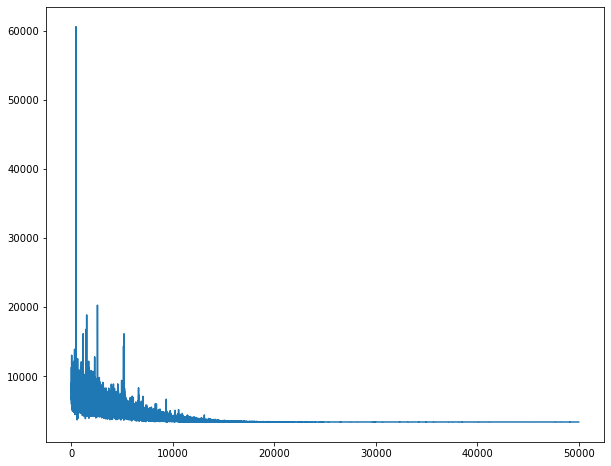

In [26]:
print("Start time {}".format(datetime.datetime.now().time()))

full_posterior, full_approximation = run_model(Xn_train, yn_train, num_iter, sample_size)

print("Finish time {}".format(datetime.datetime.now().time()))

plt.figure(figsize=(10, 8))
plt.plot(full_approximation.hist);

In [27]:
# prediction
ll=np.mean(full_posterior['alpha']) + np.dot(np.mean(full_posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]

print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  581033.7637634798
MAPE =  0.9999958190944384


## Clustering <a id='clustering'></a>

### Full Model

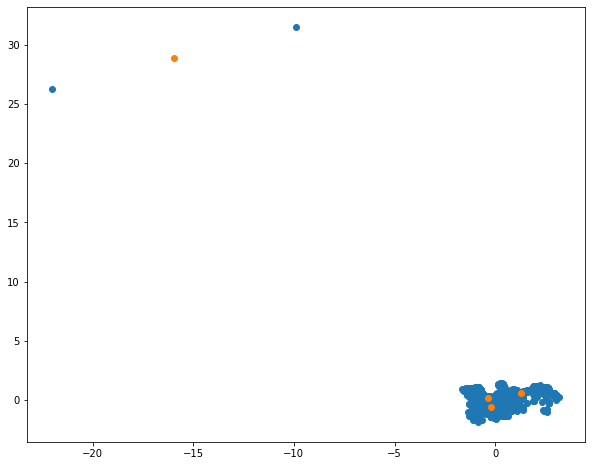

In [28]:
# training gaussian mixture model 
gmm = GaussianMixture(n_components=4)

# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])

# Gaussian Mixture
gmm.fit(X_ind)

# plot blue dots
plt.figure(figsize=(10, 8))
plt.scatter(X_ind[:,0],X_ind[:,1])

# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

## Clusters
TBD... put these in for loop - `num_models`

#### Cluster 0 - longitude and latitude ?  <a id='cluster_0'></a>

#### Training clusters

In [29]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 543, 1: 1411, 2: 2, 3: 903}

#### Testing clusters

In [30]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 99, 1: 264, 3: 137}

#### Try 1 out before doing anything else

In [31]:
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

print("ys_train {}".format(ys_train))

# natural logarithm of of ys_train returning an empty array ...
ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
print("ylog0 {}".format(ylog0))

yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)


ys_train [[3.]
 [4.]
 [3.]
 ...
 [1.]
 [2.]
 [2.]]
ylog0 [[1.60943791]
 [1.09861229]
 [0.69314718]
 [0.69314718]
 [1.09861229]
 [1.60943791]
 [0.        ]
 [1.09861229]
 [1.09861229]
 [1.60943791]
 [0.        ]
 [1.09861229]
 [0.        ]
 [1.60943791]
 [1.38629436]
 [1.94591015]
 [0.69314718]
 [0.69314718]
 [1.60943791]
 [1.94591015]
 [0.        ]
 [0.69314718]
 [0.69314718]
 [1.60943791]
 [0.69314718]
 [0.        ]
 [1.09861229]
 [0.        ]
 [1.09861229]
 [0.        ]
 [0.        ]
 [1.09861229]
 [1.09861229]
 [0.69314718]
 [0.69314718]
 [1.38629436]
 [0.        ]
 [0.        ]
 [1.94591015]
 [0.        ]
 [0.69314718]
 [0.69314718]
 [1.09861229]
 [0.69314718]
 [0.        ]
 [1.60943791]
 [1.38629436]
 [0.        ]
 [1.38629436]
 [1.38629436]
 [2.19722458]
 [1.09861229]
 [0.69314718]
 [1.79175947]
 [0.        ]
 [0.        ]
 [0.69314718]
 [0.        ]
 [1.79175947]
 [1.09861229]
 [1.09861229]
 [0.        ]
 [1.09861229]
 [1.38629436]
 [0.        ]
 [1.09861229]
 [0.69314718]
 [1.0

In [32]:
# Same as above
# ylog, yscaler, xn, yn = train_cluster(Xn_train, Xn_test)

In [34]:
print("Start time {}".format(datetime.datetime.now().time()))

tmp_posterior, tmp_approximation = run_model(Xn0, yn0, num_iter, sample_size)

print("Finish time {}".format(datetime.datetime.now().time()))

Start time 22:48:38.187415


Finished [100%]: Average Loss = 669.31


Finish time 22:48:46.429116


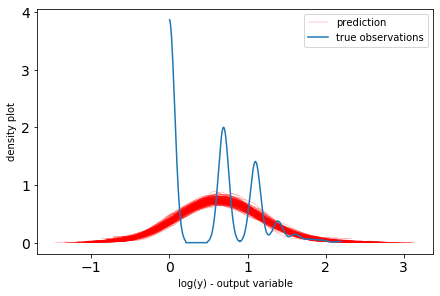

In [36]:
# Simulation
Ypred0 = yscaler0.inverse_transform(ppc(tmp_posterior['alpha'],
                                        tmp_posterior['beta'],
                                        tmp_posterior['sigma_n'],
                                        Xn0,
                                        nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
    
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

#### Cluster 1 - Number of bedrooms &  ?  <a id='cluster_1'></a>

#### Cluster 2 - Category & Type ? (property_category, property_type) ?  <a id='cluster_2'></a>

#### Cluster 3 - County & Type ?  <a id='cluster_3'></a>

### Test clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model <a id='piecewise_model'></a>
TBD - put into for loop - `num_models`

In [ ]:

# Execute the model for cluster 0
model0_posterior, approximation_0 = run_model(num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(approximation_0.hist);

In [ ]:
# Execute the model for cluster 1
model1_posterior, approximation_1 = run_model(num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(approximation_1.hist);

In [ ]:
# Execute the model for cluster 2
model2_posterior, approximation_2 = run_model(num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(approximation_2.hist)

In [ ]:
# Execute the model for cluster 3
model3_posterior, approximation_3 = run_model(num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(approximation_3.hist)

## Simulations <a id='simulations'></a>

#### Cluster 0 - longitude and latitude ?  <a id='cluster_0'></a>

In [ ]:
# Simulate cluster 0
cluster_sim(model0_posterior)

#### Cluster 1 - Number of bedrooms &  ?  <a id='cluster_1'></a>

In [ ]:
# Simulate cluster 1
cluster_sim(model1_posterior)

#### Cluster 2 - Category & Type ? (property_category, property_type) ?  <a id='cluster_2'></a>

In [ ]:
# Simulate cluster 2
cluster_sim(model2_posterior)

#### Cluster 3 - County & Type ?  <a id='cluster_3'></a>

In [ ]:
# Simulate cluster 3
cluster_sim(model3_posterior)

## Overall

## Test set performance <a id='test_set_perf'></a>

### PPC on the Test set



# Summary
### Basic understanding

section [piecewise_model](#piecewise_model)
[](#)
[](#)

[piecewise_regression](#piecewise_regression)
[clustering](#clustering)
[simulations](#simulations)
[test_set_perf](#test_set_perf)

### References
#### Websites
#### https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/
#### https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
#### https://www.cs.cornell.edu/courses/cs4110/2016fa/lectures/lecture33.html
#### http://www.henry.k12.ga.us/ugh/apstat/chapternotes/7supplement.html
#### https://online.stat.psu.edu/stat414/lesson/14/14.1

#### Books/Papers etc
#### https://www.colorado.edu/amath/sites/default/files/attached-files/ch3_0.pdf